<p style="font-family:Muro;font-weight:bold;font-size:55px;margin:5px 0px 50px 0px;color:#A04720">Social Graphs 2021</p>
<p style="font-family:Verdana;font-weight:light;font-size:35px;margin:5px 0px 10px 0px;color:#ffffff">Assignment two</p>


# Part 0

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

* Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.
    * In order to extract the hyperlinks from the Wiki-pages, the <code>bs4</code> also called <code>BeautifulSoup</code>. The characterlist was looped over, and using the <code>request</code> library, numerous requests were sent to the wikipage, locating the main containers and identifiying all the links using the <code>.findAll('a')</code> function in BS4. Thereafter, only characters that was in the characterlist were kept, and duplicates removed.

* Show the regular expression(s) you have built and explain in details how it works.
    * TbD


In [1]:
#Libs

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import ast, powerlaw
import seaborn as sns
import matplotlib.cm as cm
from fa2 import ForceAtlas2
import community as community_louvain
from collections import Counter
from collections import defaultdict
import urllib.request
import nltk
import re
import json
import math
from wordcloud import WordCloud
from nltk.corpus import stopwords
sw = stopwords.words('english')
tk = nltk.WordPunctTokenizer()


import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [2]:
#Loading in the already generated dataset
df = pd.read_csv("bowFull.csv")
#Removing an undesired column
df.drop("Unnamed: 0", inplace=True, axis=1)
#Checking the datatypes
df.dtypes


FileNotFoundError: [Errno 2] No such file or directory: 'bowFull.csv'

Upon inspecting the datatypes, it can be noted that the edges column has the dtype "object", when in reality it is a list:

In [ ]:
df['Edges'][:3]

0                ['Link', 'Nazbi', 'Savelle', 'Yammo']
1                                           ['Baumar']
2    ['Ena', 'Hylia', 'Malanya', 'Konba', 'Chork', ...
Name: Edges, dtype: object

To be able to process this data correctly, the <code>ast.literal_eval()</code> function is casted on the PD series to turn the datatype into a list

In [ ]:
df.Edges = df.Edges.map(lambda a: ast.literal_eval(a) if pd.notnull(a) else a)

Double-checking that the column has been transformed into a proper list, by accessing the elements through slicing

In [ ]:
#Should return "Nazbi"
df['Edges'][0][1]

'Nazbi'

However, pure lists doesn't work well with <code>networkx</code>, which means that each element in the 'Edges' columns needs to be transformed into each own row for the specific characters. This can be done using <code>df.explode()</code>

In [ ]:
df = df.explode("Edges")

In [ ]:
#Inspecting the first four element to ensure column has been correctly transformed
df.head(4)

,Name,Role,Race,Gender,Edges
0,Baddek,Ally,Hylian,Male,Link
0,Baddek,Ally,Hylian,Male,Nazbi
0,Baddek,Ally,Hylian,Male,Savelle
0,Baddek,Ally,Hylian,Male,Yammo


## Building the network

The <code>.from_pandas_edgelist()</code> function takes in a dataframe, a source (nodes) and a target (edges). Adding the additional argument, <code>create_using=nx.DiGraph()</code> will ensure the network is constructed with a directional graph, so bot inwards- and outwards degrees can be counted.

In [ ]:
G = nx.from_pandas_edgelist(df, 'Name', 'Edges', create_using=nx.DiGraph())

In [ ]:
#Noting that there is a "nan" node that must be removed since these don't lead to a page
list(set(list(G.nodes())))[0]

nan

In [ ]:
G.remove_node(np.nan)

### Extracting the Giant Connected Component (GCC)

The code below extracts the GCC from the network, i.e. the "central hub" where the most nodes are connected, effectively removing characters that are not meaningful to the end case. This can be a character who is only connected to their horse, which wouldn't provide much information to the overall network.

In [ ]:
GCC = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])

print(f"Nodes that were removed: {len(G.nodes()) - len(GCC.nodes)}")


Nodes that were removed: 116


## Exercise **1a**: Stats 

    * What is the number of nodes in the network?
    * What is the number of links?
    * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [ ]:
print(f"Nodes in the network: {len(GCC.nodes())}")
print(f"Number of links in the network: {len(GCC.edges())}")
topConnectedIn = sorted(GCC.in_degree, key=lambda x: x[1], reverse=True)[0]
print(f"The top connected character based on in-degrees is: {topConnectedIn[0]}, who has {topConnectedIn[1]} inwards connections.")
topConnectedOut = sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[0]
print(f"The top connected character based on out-degrees is: {topConnectedOut[0]}, who has {topConnectedOut[1]} outwards connections.")

Nodes in the network: 540
Number of links in the network: 2074
The top connected character based on in-degrees is: Link, who has 404 inwards connections.
The top connected character based on out-degrees is: Lizalfos, who has 28 outwards connections.


    Who are the top 5 most connected allies (again in terms of in/out-degree)?



In [ ]:
#Creating a function that takes in a dataframe that is modified to only contain the relevant role, and the GCC
def findTop(inputDF, inputNetwork):

    inDegree = list(sorted(inputNetwork.in_degree, key=lambda x: x[1], reverse=True))
    outDegree = list(sorted(inputNetwork.out_degree, key=lambda x: x[1], reverse=True))

    #Sub function for calculating the top five characters within the given role
    def topFive(inputList):
        counter = 0
        placeHolderList = []
        for value in inputList:
            if value[0] in list(inputDF['Name']):
                placeHolderList.append(value)
                counter += 1
            if counter == 5:
                return placeHolderList
            
    inDegreeList = topFive(inDegree)
    outDegreeList = topFive(outDegree)

    #Returning both in- and out degree for the relevant characters
    return inDegreeList, outDegreeList

#Function for printing out the relevant information
def printTop(inputList, types, inOut, amount=5):

    print(f"\n-----Top {amount} {types} with {inOut} degree------")
    
    for i, character in enumerate(inputList):
        print(f"#{i}: {character}")


With the relevant functions created, creating a seperate DataFrame with only characters with the role *ally* will be selected, and printed.

In [ ]:
onlyAllies = df.loc[df['Role'] == "Ally"]

topIn, topOut = findTop(onlyAllies, GCC)


printTop(topIn, "allies", "inwards")
printTop(topOut, "allies", "outwards")


-----Top 5 allies with inwards degree------
#0: ('Link', 404)
#1: ('Hylia', 67)
#2: ('Princess Zelda', 33)
#3: ('Mipha', 25)
#4: ('Riju', 23)

-----Top 5 allies with outwards degree------
#0: ('Link', 16)
#1: ('Impa', 15)
#2: ('Traysi', 14)
#3: ('Princess Zelda', 12)
#4: ('Daruk', 11)


Again, the same for enemies and bosses.

In [ ]:
onlyEnemies = df.loc[(df['Role'] == "Enemy") | (df['Role'] =="Boss")]

topIn, topOut = findTop(onlyEnemies, GCC)

printTop(topIn, "enemies", "inwards")
printTop(topOut, "enemies", "outwards")



-----Top 5 enemies with inwards degree------
#0: ('Calamity Ganon', 105)
#1: ('Lizalfos', 27)
#2: ('Bokoblin', 26)
#3: ('Hinox', 23)
#4: ('Master Kohga', 20)

-----Top 5 enemies with outwards degree------
#0: ('Lizalfos', 28)
#1: ('Hinox', 21)
#2: ('Stone Talus', 20)
#3: ('Moblin', 18)
#4: ('Windblight Ganon', 17)


    Plot the in- and out-degree distributions.


Text(0.5, 0, 'Amount of outward links')

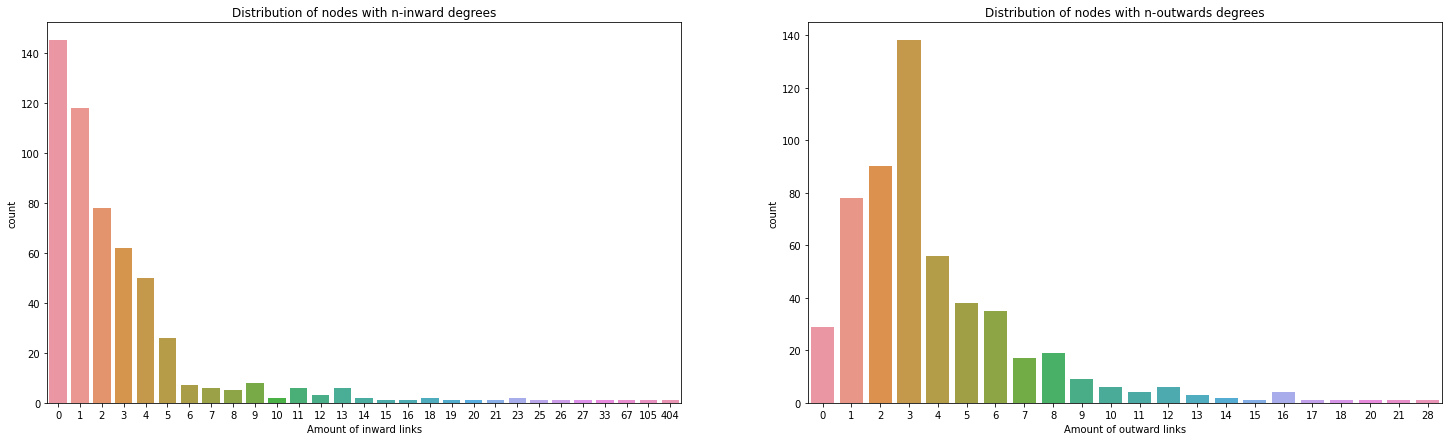

In [ ]:
#Dividing into two subplots to more easily see the differences
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(25,7)


sns.countplot(list(dict(GCC.in_degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes with n-inward degrees")
axs[0].set_xlabel("Amount of inward links")

sns.countplot(list(dict(GCC.out_degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes with n-outwards degrees")
axs[1].set_xlabel("Amount of outward links")



    What do you observe?

* Inward degree distribution
    * The inward degree distribution follows a power law like pattern, where there is a significant number of characters with none-to-small amount of inward links, and extremely few of the larger occurences. The reason for the unbelivable high amount of characters with zero inwards degrees, is that many characters in the game are rather insignificant for the main story and therefore not mentioned in othere characters' pages. Another factor can also be those characters that are so insignificant that they do not have a designated wiki page with information, e.g. <a href="https://zelda.fandom.com/wiki/Monya_Toma#Breath_of_the_Wild">Monya Toma</a>
* Outward degree distribution
    * The outward degree distribution is a bit different, having zero characters with no outward connections, looking more similar to a Poisson distribution. The reason for this is not unexpected, as the characters who would not point to another page would be removed when creating the GCC. This in turn results in many characters having one link, as there wouldn't be the need for a wikipedia page if the character would be so insignificant that they didn't connect to any other characters. The distribution is also less extreme, with the amount of outward links being incremental.


**Can you explain why the in-degree distribution is different from the out-degree distribution?**

To summarize, the difference can be explained by a combination of factors. The generation of the GCC, eliminated all "isolated nodes" and only kept the ones that had at least one outward connections. Additionally, as is stated by the power law, a network usually consists of a few central nodes, or "hubs", that has few outward links but that most other characters are connected to. Especially in video games where you have protagonists and antagonists, these characters will be extremely central and interacts with most characters at a given point. While these interactions can be central for the smaller characters, in explaining their background, they are insignificant for main characters stories, and the direction will then be one-sided.


    Find the exponent of the degree distribution (by using the powerlaw package) for the in- and out-degree distribution.


In [ ]:
def powerlaw_exponent(degreeList):
    gamma = powerlaw.Fit(degreeList).alpha
    return gamma

In [ ]:
inDegree = powerlaw_exponent(list((dict(GCC.in_degree).values())))
outDegree = powerlaw_exponent(list((dict(GCC.out_degree).values())))

Calculating best minimal value for power law fit
xmin progress: 00%
xmin progress: 03%
xmin progress: 07%
xmin progress: 11%
xmin progress: 14%
xmin progress: 18%
xmin progress: 22%
xmin progress: 25%
xmin progress: 29%
xmin progress: 33%
xmin progress: 37%
xmin progress: 40%
xmin progress: 44%
xmin progress: 48%
xmin progress: 51%
xmin progress: 55%
xmin progress: 59%
xmin progress: 62%
xmin progress: 66%
xmin progress: 70%
xmin progress: 74%
xmin progress: 77%
xmin progress: 81%
xmin progress: 85%
xmin progress: 88%
xmin progress: 92%
xmin progress: 96%
Calculating best minimal value for power law fit
xmin progress: 00%
xmin progress: 05%
xmin progress: 10%
xmin progress: 15%
xmin progress: 20%
xmin progress: 25%
xmin progress: 30%
xmin progress: 35%
xmin progress: 40%
xmin progress: 45%
xmin progress: 50%
xmin progress: 55%
xmin progress: 60%
xmin progress: 65%
xmin progress: 70%
xmin progress: 75%
xmin progress: 80%
xmin progress: 85%
xmin progress: 90%


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [ ]:
print(f"""
Exponent for the in-degree: {inDegree} 
Exponent for the out-degree: {outDegree} 
""")


Exponent for the in-degree: 2.729779372119334 
Exponent for the out-degree: 4.081957099901511 



    What does it say about our network?

The powerlaw exponent, $\gamma$, is found to be $\gamma \approx 2.7$ for the in-degree and $\gamma \approx 4$ for the out-degree. According to Barbasi (Barabasi, 4.7), this would put the in-degree network in the scale free regime, and the out-degree in the random network regime. This was expected, as multiple hubs were noticed in the in-degree network, opposed to none in the out-degree network, as is common in these networks:
> In a random network most nodes have comparable degrees and hence hubs are forbidden. Hubs are not only tolerated, but are expected in scale-free networks (Image 4.6). Furthermore, the more nodes a scalefree network has, the larger are its hubs. Indeed, the size of the hubs grows polynomially with network size, hence they can grow quite large in scalefree networks. In contrast in a random network the size of the largest node grows logarithmically or slower with N, implying that hubs will be tiny even in a very large random network. (Barbasi, 4.3)

    Compare the degree distribution of the undirected graph to a random network with the same number of nodes and probability of connection p.

When generating an Erdos Renyi graph, the parameters needed are $n$, for the amount of nodes the network should have, and $p$, the probability that a node is connected. These can be found by using the already generated GCC.


In [ ]:

N = len(GCC.nodes())
k = sum(dict(GCC.degree).values()) / len(GCC.nodes())
p = k/(N-1)

E = nx.erdos_renyi_graph(N, p)



Now that a random generated network with the same specifications have been created, the degree distributions can be plotted to measure them against each other.

Text(0.5, 0, 'Degree count')

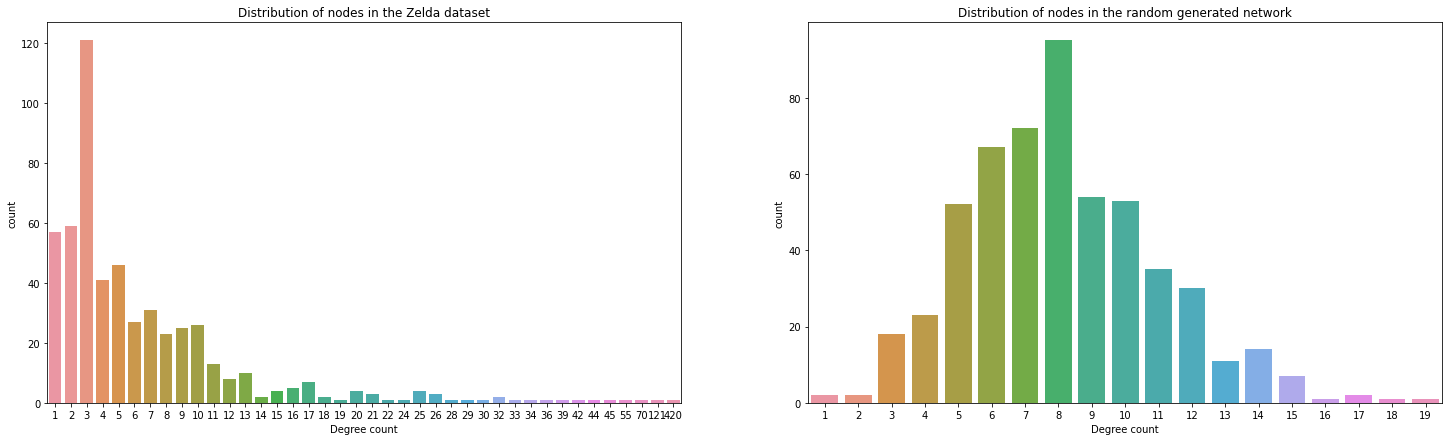

In [ ]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(25,7)


sns.countplot(list(dict(GCC.degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes in the Zelda dataset")
axs[0].set_xlabel("Degree count")

sns.countplot(list(dict(E.degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes in the random generated network")
axs[1].set_xlabel("Degree count")

    Comment your results.

Comparing the zelda dataset with the random generated ER, the differences are apparent. Firstly, the Zelda dataset follows a Powerlaw distribution and will therefore be right-tailed, where most characters have few edges, as well as some minor hubs at the very end that have a high degree count, since they are central to the video game. On the other hand, the random generated ER network will follow a normal distribution, where most of the nodes will be centered around the mean, with some outliers on both sides. 

# Exercise 1B

    * Create a nice visualization of the total (undirected) network:

As is mentioned in the task description, the network will be transformed into an undirected one to make the graph more visually appealing and easier to comprehend.

In [ ]:

V = GCC.to_undirected()

    Color nodes according to the role;

In [ ]:
def generateColorList(graphObject):
    '''
    Generates the colorList to be used in the getNodeColors function
    '''
    dfNotExploded = pd.read_csv("bowFull.csv")
    nodeList = list(graphObject.nodes())

    colorList = [dfNotExploded.loc[dfNotExploded['Name'] == node]['Role'].values[0] for node in nodeList]

    return colorList

def getNodeColors(graph):
    '''
    Returns node color map according to the Role
    '''
    color_map = []
    for role in graph:
        if role == "Ally":
            color_map.append("#50c878")
        elif role == "Enemy":
            color_map.append("#ff9100")
        else:
            color_map.append("#900000")
    return color_map

    Scale node-size according to degree;


In [ ]:

def getNodeSize(graph):
    '''
    Returns the node size based on the degree count
    '''
    degrees = dict(graph.degree)
    return [v*5 for v in degrees.values()]


In [ ]:
def get_edge_color(graph, n1, n2):
    '''
    Return edge color between two nodes
    '''
    univ1, univ2 = graph.nodes[n1]['universe'], graph.nodes[n2]['universe']
    if univ1 == univ2 == 'marvel':
        return 'blue'
    if univ1 == univ2 == 'dc':
        return 'yellow'
    return 'green'


def get_edge_color_map(graph):
    '''
    Returns edge color map taking universe into account
    '''
    return [get_edge_color(graph, n1, n2) for n1, n2 in graph.edges]

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)

positions = ForceAtlas2().forceatlas2_networkx_layout(V, pos=None, iterations=500)
nx.draw_networkx_nodes(
    V,
    positions,
    node_size=getNodeSize(V),
    node_color=getNodeColors(generateColorList(V)))
nx.draw_networkx_edges(
    V,
    positions,
    width=0.1
    # edge_color=get_edge_color_map(zeldaUndirected)
    )

# nx.draw_networkx_labels(G0[:5], positions)


plt.axis('off')
caption = '''
Figure x. Zelda Graph.
'''
plt.figtext(0.5, 0, caption, wrap=True, horizontalalignment='center', fontsize=12)
ax.set_facecolor("#FFFFFF")
plt.show()



'\nfig, ax = plt.subplots()\nfig.set_size_inches(20,10)\n\npositions = ForceAtlas2().forceatlas2_networkx_layout(V, pos=None, iterations=500)\nnx.draw_networkx_nodes(\n    V,\n    positions,\n    node_size=getNodeSize(V),\n    node_color=getNodeColors(generateColorList(V)))\nnx.draw_networkx_edges(\n    V,\n    positions,\n    width=0.1\n    # edge_color=get_edge_color_map(zeldaUndirected)\n    )\n\n# nx.draw_networkx_labels(G0[:5], positions)\n\n\nplt.axis(\'off\')\ncaption = \'\'\'\nFigure x. Zelda Graph.\n\'\'\'\nplt.figtext(0.5, 0, caption, wrap=True, horizontalalignment=\'center\', fontsize=12)\nax.set_facecolor("#FFFFFF")\nplt.show()\n'

# Part 2: Word-clouds

> Here we are going to create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions), based on info from the Zelda Wiki.

First, the pages from the wiki are downloaded and extracted. The library urlib.request is used to make a API-call to the wiki. Then, every page is save into their own .txt file. This is done to save whoever is running this notebook some computing time. The .txt-files will be included in the zip.

In [ ]:
df_characters = pd.read_csv('ZeldaBotW_nodes_w_attributes_enriched.csv')
names = df_characters['Name'].tolist()
names2 = ['Ancient Oven' if x == 'Cherry' else x for x in names]
names3 = [x.replace(" ", "_") for x in names2]

def get_json(title):
    title1 = urllib.parse.quote_plus(title)
    baseurl = "https://zelda.fandom.com/api.php?"
    action = "action=query"
    title = f'titles={title1}'
    content="prop=extracts&exlimit=1&explaintext"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    return title1, list(json.loads(wikitext)['query']['pages'].values())[0]['extract']

def write_to_txt(title, text):
    text_file = open(f"{title}.txt", "w")
    n = text_file.write(text)
    text_file.close()

#for name in names3:
#    info = get_json(name)
#    write_to_txt(info[0], info[1])

Now the downloaded text needs to ble cleaned. To clean the text, the individual files are opened and read. Then, headers ('== Biography ==', etc.) and punctuation are removed with regex. Everything that comes after '== Nomeclature ==' is also removed, because it is only redudant information.
Then, the text is split into tokens and the code removes character names and stopwords. Lastly, the tokens are lemmatized.

In [ ]:
def cleaned_txt(filename):
    with open(f"pages\{filename}") as f:
        contents = f.read()
    f.close()

    new_contents = contents.replace('\n', ' ')
    res1 = re.sub(r"== Nomenclature ==.*", " ", new_contents)
    res2 = re.sub(r'\==[^====]*\==',  '', res1)
    res3 = re.sub(r'[^\w\s]', '', res2)
    tokens = tk.tokenize(res3)
    for name in names:
        try:
            while True:
                tokens.remove(name)
        except ValueError:
            pass

    new_tokens = [token.lower() for token in tokens]
    for word in sw:
        try:
            while True:
                new_tokens.remove(word)
        except ValueError:
            pass

    wnl = nltk.WordNetLemmatizer()
    output = [wnl.lemmatize(t) for t in new_tokens]
    return output

After the text is tokenized, the individual character's text will be combined into a list.

In [ ]:
def combine_and_convert(titles_input):
    all_tokens = []
    for title in titles_input:
        all_tokens.append(cleaned_txt(title))
    return sum(all_tokens, [])


Now that the texts can be cleaned and combined, there is made five 'texts', one for each of the races of the five champions of Hyrule (Hylian, Zora, Goron, Gerudo, and Rito). 

In [ ]:
def make_text(race):
    names = [x.replace(" ", "_") for x in df_characters[df_characters['Race'] == race]['Name'].tolist()]
    titles = [urllib.parse.quote_plus(x) + '.txt' for x in names]
    return nltk.Text(combine_and_convert(titles))

hylian = make_text('Hylian')
zora = make_text('Zora')
goron = make_text('Goron')
gerudo = make_text('Gerudo')
rito = make_text('Rito')

Then, a list with the races are made for later use in the idf.

In [ ]:
texts = [hylian, zora, goron, gerudo, rito]

Now it is time for the TC-IDF. First, the TCs for each document (race) are computed. Then, the IDFs for every word across the five documents are computed.

In [ ]:
def tc(text):
    tc = {}
    for key, value in nltk.FreqDist(text).items():
        tc[key] = value
    return tc

def idf(texts):
    text = nltk.TextCollection(texts)
    idf = {}
    for word in text:
        idf[word] = text.idf(word)
    return idf

idfs = idf(texts)

def tc_idf(text):
    tc_ = tc(text)
    tc_idf = {}
    for word in text:
        tc_idf[word] = int(math.ceil(idfs[word])) * tc_[word]
    return tc_idf

Now, there are methods to compute TC-IDF, and words in Word-clouds. The documents are converted to strings, and used to make Word-clouds.

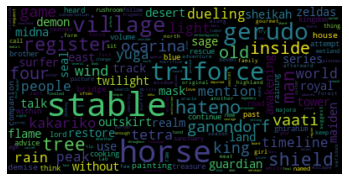

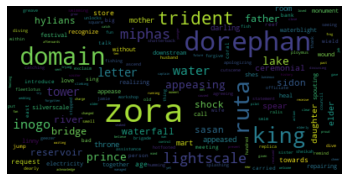

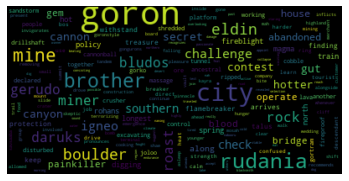

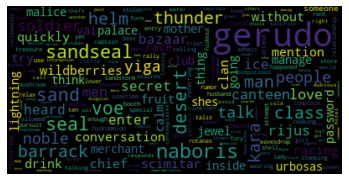

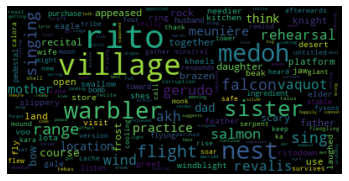

In [ ]:
def make_wordclouds():
    for text in texts:
        string = ""
        for key, value in tc_idf(text).items():
            string += ((key  + " ") * value)
        wordcloud = WordCloud(max_font_size=40, collocations=False).generate(string)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

make_wordclouds()

* Comment on your results:
    * There are images with a lot of information about the five races. 
    * The Hylians are all about stables, horses, and the village and are maybe more home-loving than the other races. They also seem to have some connections to the Gerudos and cares a lot about the tri-force. 
    * The Zora care a lot about their king, Dorephan, and his trident. His throne room is in Zora's Domain, which is also prevalent. 
    * The Gorons are all about challenges and contests. They are a rock people, so they are described by boulders, miner, gems and rocks.
    * The Gerudo are female pirates who live in the desert, so the words that describe them are sandseal, sand, desert. 
    

# Part 3: Communities and TF-IDF

Now, the Zelda-network created in Part 1 will be used to find communities, by the Louvain-algorithm. Then the communities' associated TF-ID will be computed. 

* Explain the Louvain algorithm and how it finds communities in a newtork.
    * The Louvain algorithm makes the communities by optimizing the modularity of the network. First, it creates relative small communities by optimizing the modularity on small parts of the network. It individually chooses nodes, and calculates change in modularity, and does this for every node and creates small communities. It then uses nodes in the same community and builds a new network where the nodes are the communities (nodes in the same community becomes one node). It then does tihs iteratively until it gets max modularity.
* Explain how you chose to identify the communities: Which algorithm did you use?
    * The Louvain algorithm was used, which comes included as a python package in the form of community.best_partition(). Here, best_partition is the partition with highest modularity (the highest partition of the dendrogram generated by the Louvain algorithm)

Following, the best_partition() method is used on the Zelda network. 
The following code answers these questions:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot the distribution of community sizes.
    
    

We found 21 communities in total.
The modularity of the partition created is 0.5677156058430189.


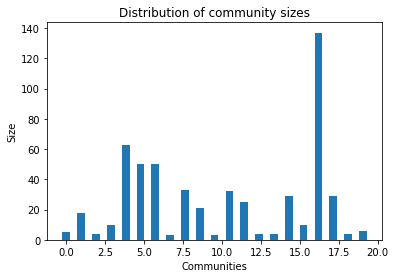

In [ ]:
partition = community_louvain.best_partition(V, randomize=False)
count = len(set(partition.values()))
modu = community_louvain.modularity(partition, V)
print(f"{count} communities were found in total.")
print(f"The modularity of the partition created is {modu}.")

data = list(partition.values())
five_largest = []
for elem in Counter(data).most_common(5):
    five_largest.append(elem[0])

values, bins = np.histogram(list(partition.values()), count)
plt.bar(bins[:-1], values, width=0.5)
plt.title('Distribution of community sizes')
plt.xlabel('Communities')
plt.ylabel('Size')
plt.show()


As you can see, there are 21 communities in the Zelda network. The modularity of the partition is 0.5677, which suggests a really good partition (values closer to 0 are worse). 
By the plot of the distributions, one can see that one of the communities is much larger the others, and there are also some small ones. The following code analyzes the five largest ones. You can uncomment the for-loop with the print statements if you want to see the characters in the communities.

In [ ]:
communities = defaultdict(list)
for k, v in partition.items():
    communities[v].append(k)
    
#for i in five_largest:
#    print(f"Community {i}:")
#    print(communities[i])
#    print("-----------")

Now it is time to compute TF-IDF. The TF is computed by first getting the frequency distribution from the method provided with nltk. This gives every word count. Then the term count (TC) is divided with the number of words in the document, and results in the term frequency (TF). This is done for every word in each of the five communities. Here, a built-in function could have been used, but the frequency distribution gives exactly what is needed.

Then the IDF of all the words across the communities are computed with nltk's built-in method "idf()". This method was chosen because it wasn't necessary to "re-invent the wheel". The last part is to multiply each word's TF in each document with the word's corresponding IDF. This results in TF-IDF for each word in each of the communities. Now they get sorted, and the top 5 words are sliced, and then printed.

In [ ]:
def tf_idf():
    text_list = []
    text_dict = {}
    tf_total = {}
    print("Top five words according to tf for the five largest communities:\n")
    for i in five_largest:
        names = [x.replace(" ", "_") for x in ['Ancient Oven' if x == 'Cherry' else x for x in communities[i]]]
        titles = [urllib.parse.quote_plus(x) + '.txt' for x in names]
        text = nltk.Text(combine_and_convert(titles))
        text_list.append(text)
        text_dict[i] = text
        tf = {}
        for key, value in nltk.FreqDist(text).items():
            tf[key] = value/(len(text))
        tf_total[i] = tf
        top5 = (sorted(tf.items(), key = lambda x: x[1], reverse = True)[:5])
        print(f"Community {i}:")
        for i in range(len(top5)):
            print(f"{i+1}: {top5[i][0]}")
        print("\n")
    
    mytext = nltk.TextCollection(text_list)
    idf = {}
    for word in mytext:
        idf[word] = mytext.idf(word)
    
    print("Top five words according to tf-idf for the five largest communities:\n")
    for j in five_largest:
        tf_idf = {}
        for word in text_dict[j]:
            tf_idf[word] = int(idf[word]) * tf_total[j][word]
        top5 = (sorted(tf_idf.items(), key = lambda x: x[1], reverse = True)[:5])
        print(f"Community {j}:")
        for i in range(len(top5)):
            print(f"{i+1}: {top5[i][0]}")
        print("\n")

tf_idf()

Top five words according to tf for the five largest communities:

Community 17:
1: gerudo
2: town
3: tell
4: wild
5: say


Community 4:
1: shrine
2: monk
3: sheikah
4: calamity
5: breath


Community 5:
1: zelda
2: princess
3: hyrule
4: time
5: ganon


Community 6:
1: attack
2: appear
3: chuchus
4: moblins
5: fire


Community 8:
1: goron
2: city
3: breath
4: wild
5: character


Top five words according to tf-idf for the five largest communities:

Community 17:
1: barrack
2: allowed
3: drink
4: rijus
5: sandstorm


Community 4:
1: ostracism
2: entered
3: maag
4: emblem
5: kosah


Community 5:
1: maz
2: koshia
3: timeline
4: raw
5: pumpkin


Community 6:
1: lynels
2: variant
3: jelly
4: chu
5: wizzrobes


Community 8:
1: cannon
2: dragonfly
3: bludos
4: wedding
5: miner




TODO: comment on what the difference in words mean.